# Association Rules Mining with MLxtend_library

Association analysis using the apriori algorithm and the MLxtend library. 

- [MLxtend documentation example](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/) for generation of frequent item sets with Apriori algorithm
- [MLxtend documentation example](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/) for Association Rules


**Data Sources:**

- `data/raw/sales_total.csv`: real transaction dataset for a B2B retailer.

**Changes**

- 2019-07-07: Start notebook


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries,-load-data" data-toc-modified-id="Import-libraries,-load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries, load data</a></span></li><li><span><a href="#Prepare-basic-data-structure" data-toc-modified-id="Prepare-basic-data-structure-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare basic data structure</a></span></li><li><span><a href="#Get-frequent-itemsets-with-Apriori-algorithm" data-toc-modified-id="Get-frequent-itemsets-with-Apriori-algorithm-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Get frequent itemsets with Apriori algorithm</a></span></li><li><span><a href="#Generate-Association-Rules" data-toc-modified-id="Generate-Association-Rules-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Generate Association Rules</a></span></li></ul></div>

---

## Import libraries, load data

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from tqdm import tqdm

# Specials
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

# My functions
import EDA_functions as EDA
import cleaning_functions as cleaning

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns 
# sns.set_style('whitegrid')
color = 'rebeccapurple'
%matplotlib inline

# Display settings
from IPython.display import display
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [2]:
# Load data
transactions_raw = pd.read_csv('data/raw/sales_total.csv', parse_dates=['Fakturadatum'])

## Prepare basic data structure

**IMPORTANT:** Using MLxtnd this analysis requires that all the data for a transaction be included in 1 row and the items should be 1-hot encoded.

In [3]:
transactions_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2835054 entries, 0 to 2835053
Data columns (total 12 columns):
Kunde           int64
Fakturadatum    datetime64[ns]
Faktura         int64
Pos             int64
Artikel         object
Unit Price      float64
pro             int64
ME              object
Menge           float64
ME.1            object
Nettowert       float64
Währg           object
dtypes: datetime64[ns](1), float64(3), int64(4), object(4)
memory usage: 259.6+ MB


In [4]:
transactions_raw.sample(2)

,Kunde,Fakturadatum,Faktura,Pos,Artikel,Unit Price,pro,ME,Menge,ME.1,Nettowert,Währg
2278256,8154143,2018-08-22,92174310,6,6505863,1.65,1,ST,2.0,ST,3.30,CHF
140949,8775001,2017-02-14,91556395,3,2712202,7.75,1,ST,1.0,ST,7.75,CHF


In [5]:
"""Clean and re-formate data"""

# Look at 2018 data only
transactions_18_full = transactions_raw.loc[transactions_raw['Fakturadatum'].dt.year == 2018]
transactions_18_full = transactions_18_full[['Kunde', 'Fakturadatum', 'Artikel']]

# Kick out all artikel that contain str values in their code
print("Unique artikel before cleaning:", transactions_18_full['Artikel'].nunique())
transactions_18_full['Artikel'] = pd.to_numeric(transactions_18_full['Artikel'], errors='coerce')
transactions_18 = transactions_18_full.dropna(how='any')
print("Unique artikel after cleaning:", transactions_18['Artikel'].nunique())

# Kick-out special customers
transactions_18 = transactions_18.loc[transactions_18['Kunde'] > 700000]

# Groupby
transactions_18_grouped = pd.DataFrame(transactions_18.groupby(
        ['Kunde', 'Fakturadatum'])['Artikel'].unique())
transactions = transactions_18_grouped.reset_index(drop=True)

Unique artikel before cleaning: 74126
Unique artikel after cleaning: 49709


**Note:** By keeping numeric artikel IDs only I loose about a third of artikel! But let's do it anyway.

In [6]:
# Check results
print("Number of transactions:", len(transactions))
transactions.head()

Number of transactions: 204330


,Artikel
0,"[9900179.0, 4100130.0, 5308748.0, 5074021.0, 5..."
1,"[2960232.0, 5308591.0, 6436018.0, 66933.0, 629..."
2,"[4921011.0, 2947803.0, 2550805.0, 2458003.0, 6..."
3,"[7947701.0, 6634351.0, 7906101.0, 8621604.0, 6..."
4,"[2119635.0, 2119634.0, 2310306.0, 6103861.0, 8..."


In [7]:
"""OHE to sparse format with MLxtnd TransactionEncoder"""

te = TransactionEncoder()
products_array = np.array(transactions['Artikel'])
products_array_ohe = te.fit(products_array).transform(products_array, sparse=True)
transactions_sparse = pd.SparseDataFrame(products_array_ohe, 
                                        columns=te.columns_, 
                                        default_fill_value=False)

assert transactions_sparse.iloc[1,].sum() == len(transactions.iloc[1,0])

In [8]:
# # Check results
# transactions_sparse.head()

## Get frequent itemsets with Apriori algorithm

**Note:** Due to current limitations in Pandas, if the SparseDataFrame has integer column names,names, please make sure they either start with `0` or cast them as string column names: `df.columns = [str(i) for i in df.columns`].

In [9]:
transactions_sparse.columns = [str(i) for i in transactions_sparse.columns]

# Set a low min_support to get many sets
frequent_itemsets = apriori(transactions_sparse, min_support=0.001, 
                            use_colnames=True, max_len=None, verbose=1)

Iteration: 480407 | Sampling itemset size 4


In [46]:
"""Save / Load itemsets for convencience"""

# frequent_itemsets.to_csv('data/interim/frequent_itemsets.csv', index=False)
frequent_itemsets = pd.read_csv('data/interim/frequent_itemsets.csv')

# Check results
frequent_itemsets.info()
display(frequent_itemsets.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 2 columns):
support     1148 non-null float64
itemsets    1148 non-null object
dtypes: float64(1), object(1)
memory usage: 18.0+ KB


,support,itemsets
0,0.001542,frozenset({'24832.0'})
1,0.001091,frozenset({'25123.0'})
2,0.001106,frozenset({'40721.0'})
3,0.001904,frozenset({'56614.0'})
4,0.002271,frozenset({'61855.0'})


**Note:** There is an issue with the frozenset dtype. After saving and reloading the dataframe it gets returned as object and I don't know (yet) how to convert it correctly back to that format while reading in the dataframe.

In [47]:
# Restore dtype frozenset
frequent_itemsets['itemsets'] = frequent_itemsets['itemsets'].str.strip('frozenset({})')
frequent_itemsets['itemsets'] = frequent_itemsets['itemsets'].str.split(',')
frequent_itemsets['itemsets'] = frequent_itemsets['itemsets'].apply(frozenset)
assert type(frequent_itemsets['itemsets'][0]) == frozenset

In [48]:
# Add length of individual itemsets (if you later want to filter for length)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

In [49]:
# Check results
print("Number of frequent sets with support > {}: {}".format(0.001, len(frequent_itemsets))) 
print("Of those, number of sets with more than 1 item:", 
      len(frequent_itemsets.loc[frequent_itemsets['length'] > 1]))

display(frequent_itemsets.tail())

Number of frequent sets with support > 0.001: 1148
Of those, number of sets with more than 1 item: 182


,support,itemsets,length
1143,0.001111,"('6327912.0', '6327901.0', '6327911.0')",3
1144,0.001067,"( '6327901.0', '6327922.0', '6327911.0')",3
1145,0.001077,"( '6327912.0', '6327901.0', '6327922.0')",3
1146,0.001042,"( '6327932.0', '6327901.0', '6327922.0')",3
1147,0.001483,"( '6115231.0', '6115232.0', '6115230.0', '61...",4


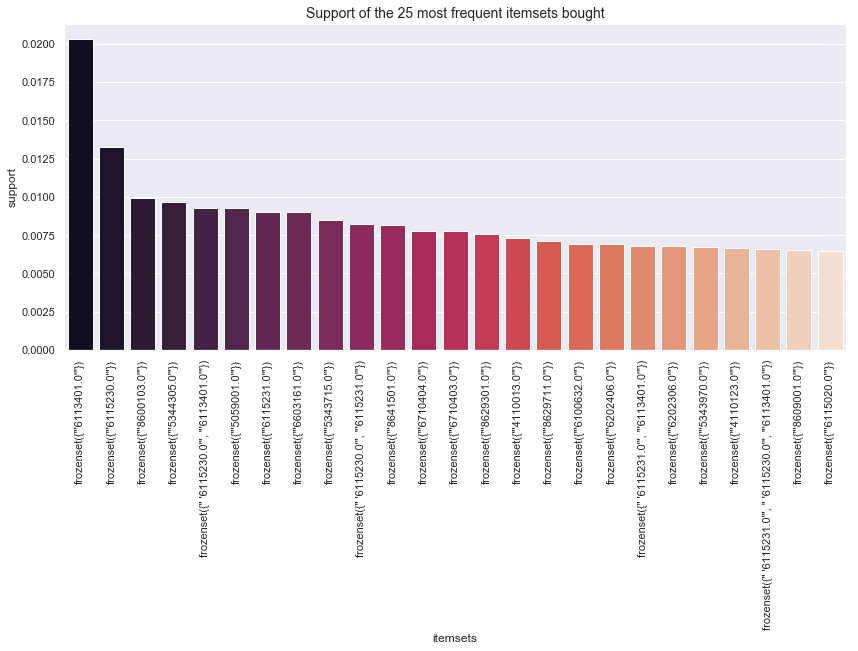

In [51]:
"""Plot support for most frequent item sets / items"""

plt.figure(figsize=(14,6))
plot_df = frequent_itemsets.sort_values(['support'], ascending=False).head(25).reset_index(drop=True)
sns.barplot(y='support', x="itemsets", data=plot_df, palette='rocket')
plt.title("Support of the 25 most frequent itemsets bought", size=14)
plt.xticks(rotation=90);

**Findings:** This bar plot illustrates the item sets / items that are frequently bought at this store, and it is notable that the support of even the most frequent items is relatively low (for example, the most frequent item occurs in only around 2% of transactions). We use these insights to inform the minimum threshold when generating the association rules; for example, we know that in order for the algorithm to return a reasonable number of rules we’ll need to set the support threshold at well below 0.02.

## Generate Association Rules

In [81]:
"""NOT WORKING YET"""

# Manually remove rows containing artikels where antecedent or cosequent info is missing (WIP ...)
freq_sets = frequent_itemsets.drop([28, 966, 30, 967, 31, 968, 62, 969, 971, 1124, 63, 970, 971, 1124, 
                                   125, 972, 973, 1125, 129, 974, 130, 973, 975, 1125, 150, 976, 181, 977,
                                   187, 978, 189, 979, 215, 980, 226, 981, 269, 982, 231, 983, 238, 984,
                                   253, 985, 259, 986, 987, 272, 988, 283, 989, 990, 1126, 284, 989, 991, 1126,
                                   286, 992, 300, 993, 299, 994, 310, 995, 331, 996, 360, 997, 363, 998, 
                                   414, 999, 409, 1000, 1010, 1127, 410, 1001, 1011, 1128, 411, 1002, 1010, 1127,
                                   412, 1003, 1011, 1128, 415, 1004, 1012, 1129, 416, 1005, 1013, 1130,
                                   417, 1006, 1014, 1131, 418, 1007, 1013, 1130, 419, 1008, 1014, 1131, 
                                   420, 1009, 1012, 1129,  
                                   ], axis=0)
print(len(freq_sets))
# Generate rules with min_threshold for lift
rules = association_rules(freq_sets, metric='lift', min_threshold=0.00001)

1053


KeyError: 'frozenset({" \'5344584.0\'"})You are likely getting this error because the DataFrame is missing  antecedent and/or consequent  information. You can try using the  `support_only=True` option'

In [86]:
"""INCOMPLETE DATAFRAME"""

rules = association_rules(freq_sets, support_only=True, min_threshold=0.001)

In [69]:
# Check results
rules[['antecedents', 'consequents', 'support']]

,antecedents,consequents,support
0,( '4228109.0'),('4228009.0'),0.001160
1,('4228009.0'),( '4228109.0'),0.001160
2,('4752311.0'),( '4752351.0'),0.001703
3,( '4752351.0'),('4752311.0'),0.001703
4,('4891001.0'),( '4891621.0'),0.001595
5,( '4891621.0'),('4891001.0'),0.001595
6,('4905011.0'),( '4905001.0'),0.002501
7,( '4905001.0'),('4905011.0'),0.002501
8,( '4905501.0'),('4905502.0'),0.001038
9,('4905502.0'),( '4905501.0'),0.001038


In [52]:
test = frequent_itemsets.copy()

In [53]:
test['itemsets'] = test['itemsets'].astype(str)

In [54]:
test['itemsets'].head()

0    frozenset({"'24832.0'"})
1    frozenset({"'25123.0'"})
2    frozenset({"'40721.0'"})
3    frozenset({"'56614.0'"})
4    frozenset({"'61855.0'"})
Name: itemsets, dtype: object

In [82]:
test.loc[test['itemsets'].str.contains('5344584.0')].index

Int64Index([420, 1009, 1012, 1129], dtype='int64')